#  Deep Learning and Image Recognition

## LSTM Airline Time Series

#### LSTM for international airline passengers 

In [1]:
import os
from six import moves
import ssl

import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


### Fetch Data

In [2]:
path = "international-airline-passengers.csv"
if not os.path.isfile(path):
    context = ssl._create_unverified_context()
    moves.urllib.request.urlretrieve("https://raw.githubusercontent.com/blue-yonder/pydse/master/pydse/data/international-airline-passengers.csv", path)

In [3]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = read_csv('international-airline-passengers.csv',sep=';',usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

### Train LSTM

In [4]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

#print(testX)
#print(testY)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 3s - loss: 0.0406
Epoch 2/100
 - 1s - loss: 0.0200
Epoch 3/100
 - 1s - loss: 0.0146
Epoch 4/100
 - 1s - loss: 0.0135
Epoch 5/100
 - 1s - loss: 0.0124
Epoch 6/100
 - 1s - loss: 0.0116
Epoch 7/100
 - 1s - loss: 0.0105
Epoch 8/100
 - 1s - loss: 0.0096
Epoch 9/100
 - 1s - loss: 0.0086
Epoch 10/100
 - 1s - loss: 0.0075
Epoch 11/100
 - 1s - loss: 0.0066
Epoch 12/100
 - 1s - loss: 0.0056
Epoch 13/100
 - 1s - loss: 0.0049
Epoch 14/100
 - 1s - loss: 0.0041
Epoch 15/100
 - 1s - loss: 0.0035
Epoch 16/100
 - 1s - loss: 0.0030
Epoch 17/100
 - 1s - loss: 0.0027
Epoch 18/100
 - 1s - loss: 0.0024
Epoch 19/100
 - 1s - loss: 0.0022
Epoch 20/100
 - 1s - loss: 0.0021
Epoch 21/100
 - 1s - loss: 0.0020
Epoch 22/100
 - 1s - loss: 0.0020
Epoch 23/100
 - 1s - loss: 0.0020
Epoch 24/100
 - 1s - loss: 0.0020
Epoch 25/100
 - 1s - loss: 0.0019
Epoch 26/100
 - 1s - loss: 0.0020
Epoch 27/100
 - 1s - loss: 0.0020
Epoch 28/100
 - 1s - loss: 0.0019
Epoch 29/100
 - 1s - loss: 0.0019
Epoch 30/100
 - 1s - lo

### Predict

In [5]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 22.34 RMSE
Test Score: 45.66 RMSE


### Plot

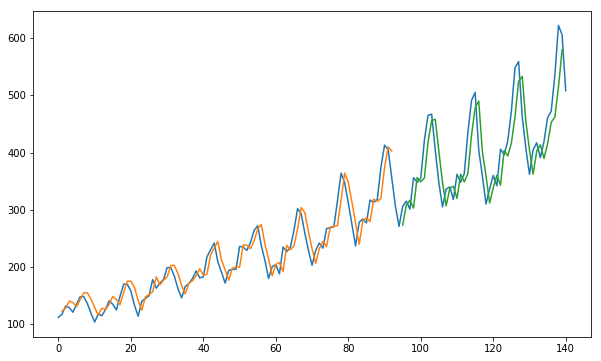

In [6]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.figure(figsize=(10,6))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()